### Library Import

In [150]:
import os
import pandas as pd
import numpy as np
import pickle

import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['text.color'] = 'white'#'#aaaaaa'
plt.rcParams.update({'text.color': "white",
                     'axes.labelcolor': "white"})

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorboard.plugins.hparams import api as hp
%load_ext tensorboard

import altair as alt
import seaborn as sns

import importlib

import warnings
warnings.filterwarnings('ignore')


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [159]:
# load in test_train_split custom function
from sklearn.metrics import confusion_matrix
import train
importlib.reload(train)
from train import test_train_split, train_test_model, run
import charts
importlib.reload(charts)
from charts import line_chart, plot_confusion_matrix_2, plot_roc, plot_metrics, plot_images, visualize

# Loading in Images

#### From pickeled files
For loading the images for the model simply run the the below code

In [152]:
# to load image files from pickles both train and test
dir = os.getcwd()

with open('{}/artifacts/{}'.format(dir, 'train_images_unrealEvenish_pkl.pkl'), 'rb') as pickle_file: #train_images_pkl_all.pkl
    train_data = pickle.load(pickle_file)

with open('{}/artifacts/{}'.format(dir, 'test_images_pkl_uneven_w_drone.pkl'), 'rb') as pickle_file: #test_images_pkl_even_ratio.pkl
    test_data = pickle.load(pickle_file)


Now that we have loaded the images we can split the training set in to training, development and test images. We have imported a function that we have created for this. 

In [153]:
#splitting in to test train split for the training data
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(train_data)
# print(np.array(train_images).shape)
# print(np.array(train_labels).shape)

# ###############################
# #Manual data augmentation flow#
# ###############################

# #FLIPPING
# augmented_train_images = []
# augmented_train_labels = []
# for i in range(len(train_images)):
#     augmented_train_images.append(tf.image.flip_left_right(train_images[i]))
#     augmented_train_labels.append(train_labels[i])
#     # flipped = tf.image.flip_left_right(image, 0.4)
#     # visualize(image, flipped)

# train_images = tuple(list(train_images) + augmented_train_images)
# train_labels = train_labels + tuple(augmented_train_labels)

# #SATURATION
# # saturated_train_images = []
# # saturated_train_labels = []
# # for i in range(len(train_images)):
# #     saturated_train_images.append(tf.image.adjust_saturation(train_images[i], 2))
# #     saturated_train_labels.append(train_labels[i])


# # train_images = tuple(list(train_images) + saturated_train_images)
# # train_labels = train_labels + tuple(saturated_train_labels)

# # #BRIGHTNESS
# # bright_train_images = []
# # bright_train_labels = []
# # for i in range(len(train_images)):
# #     bright_train_images.append(tf.image.adjust_brightness(train_images[i], 0.4))
# #     bright_train_labels.append(train_labels[i])

# # train_images = tuple(list(train_images) + bright_train_images)
# # train_labels = train_labels + tuple(bright_train_labels)

# # #CONTRAST
# # contrast_train_images = []
# # contrast_train_labels = []
# # for i in range(len(train_images)):
# #     contrast_train_images.append(tf.image.adjust_contrast(train_images[i], 0.4))
# #     contrast_train_labels.append(train_labels[i])

# # train_images = tuple(list(train_images) + contrast_train_images)
# # train_labels = train_labels + tuple(contrast_train_labels)



#normalize the images
train_images, dev_images, test_images = np.array(train_images) / 255.0, \
                                        np.array(dev_images) / 255.0, \
                                        np.array(test_images) / 255.0

# print(train_images.shape)
# print(train_labels.shape)

train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

input_shape = train_images.shape[1:]
print(input_shape)
print(train_images.shape)
print(train_labels.shape)


(100, 195, 3)
(1030, 100, 195, 3)
(1030, 1)


In [154]:
hold_out_images, hold_out_labels = zip(*test_data)

images_final_test = []
for img in hold_out_images:
    img = Image.fromarray(img)
    img = img.resize((input_shape[1], input_shape[0])) #change to shape of train images
    images_final_test.append(np.array(img))

hold_out_images = images_final_test

#normalize the images
hold_out_images = np.array(hold_out_images) / 255.0


# augmented_hold_out_images = []
# augmented_hold_out_labels = []
# for i in range(len(hold_out_images)):
#     augmented_hold_out_images.append(tf.image.flip_left_right(hold_out_images[i]))
#     augmented_hold_out_labels.append(hold_out_labels[i])

# hold_out_images = tuple(list(hold_out_images) + augmented_hold_out_images)
# hold_out_labels = hold_out_labels + tuple(augmented_hold_out_labels)

hold_out_images = tf.convert_to_tensor(hold_out_images , dtype=tf.float32)
hold_out_images.shape[1:]

# plot_images(hold_out_images, hold_out_labels)

TensorShape([100, 195, 3])

In [155]:
#view the split of the data
df = pd.DataFrame([label[0] for label in train_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['train_data_label', 'count_of_label']
df

,train_data_label,count_of_label
0,0.0,554
1,1.0,476


In [156]:
#view the split of the data
df = pd.DataFrame([label[0] for label in hold_out_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['hold_out_label', 'count_of_label']
df

,hold_out_label,count_of_label
0,0,959
1,1,10


# Hyperparameter Tuning

In [157]:
%reload_ext tensorboard
#! rm -rf ./logs/

In [160]:
session_num = 0
epochs = 10
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([32]))#, 64])) #8, 16, 16,32,
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.4, 0.5))
dropout_rate = 0.2
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))#,'adam', 'Nadam'])) #'sgd','Adagrad','RMSprop',,'Nadam','Nadam'

params = []
losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []
aucs = []
cms = []
units = []
dropouts = []
optimizers = []
histories = []
modelz = []
predictions = []

for num_units in HP_NUM_UNITS.domain.values:
#for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
  for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
        HP_NUM_UNITS: num_units,
        HP_DROPOUT: dropout_rate,
        HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      units.append(num_units)
      dropouts.append(dropout_rate)
      optimizers.append(optimizer)
      model = run('logs/hparam_tuning/' + run_name, hparams, epochs, input_shape,train_images,train_labels,test_images, test_labels,
              HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, predictions,
              params, losses, accuracies, f1_scores, precisions, recalls, cms, aucs,
              units, dropouts, optimizers, histories, augmentModel=True)
      modelz.append(model)
      session_num += 1

--- Starting trial: run-0
{'num_units': 32, 'dropout': 0.2, 'optimizer': 'adam'}
Epoch 1/10
33/33 [==============================] - 40s 1s/step - loss: 0.4671 - tp: 347.0000 - fp: 109.0000 - tn: 445.0000 - fn: 129.0000 - accuracy: 0.7689 - precision: 0.7610 - recall: 0.7290 - auc: 0.8532 - prc: 0.8608
Epoch 2/10
33/33 [==============================] - 35s 1s/step - loss: 0.1707 - tp: 445.0000 - fp: 26.0000 - tn: 528.0000 - fn: 31.0000 - accuracy: 0.9447 - precision: 0.9448 - recall: 0.9349 - auc: 0.9785 - prc: 0.9821
Epoch 3/10
33/33 [==============================] - 35s 1s/step - loss: 0.1017 - tp: 457.0000 - fp: 9.0000 - tn: 545.0000 - fn: 19.0000 - accuracy: 0.9728 - precision: 0.9807 - recall: 0.9601 - auc: 0.9900 - prc: 0.9925
Epoch 4/10
33/33 [==============================] - 36s 1s/step - loss: 0.0600 - tp: 466.0000 - fp: 10.0000 - tn: 544.0000 - fn: 10.0000 - accuracy: 0.9806 - precision: 0.9790 - recall: 0.9790 - auc: 0.9957 - prc: 0.9966
Epoch 5/10
33/33 [================

In [161]:
# # epoch20dropout23optimize3 = modelz
# epoch50dropout45optimize3 = modelz

In [162]:
#dataframe assembly for model comparison
#integrate confusion matrices as well
# epoch20dropout23optimize3Df = modelDf
# epoch20dropout23optimize3Histories = histories
# epoch50dropout45optimize3Df = modelDf
# epoch50dropout45optimize3Histories = histories

modelDf = pd.DataFrame(list(zip(units, dropouts, optimizers, losses, accuracies, aucs, precisions, recalls, cms)),# f1_scores,
               columns =['units', 'dropouts', 'optimizers', 'losses', 'accuracies', 'aucs', 'precisions', 'recalls', 'cms'])#'aucs',

modelDf

,units,dropouts,optimizers,losses,accuracies,aucs,precisions,recalls,cms
0,32,0.2,adam,0.017917,0.992248,1.0,1.0,0.984375,"[[65, 0], [1, 63]]"


In [163]:
#Best so far

# 70 TN / 13 FN / 2 FP / 57 TP -- adam / 32 units / 0.2 dropout / 10 epochs
# 54 TN / 11 FN / 18 FP / 59 TP -- Nadam / 32 units / 0.3 dropout / 10 epochs
# 35 TN / 12 FN / 37 FP / 58 TP -- adam / 16 units / 0.1 dropout / 25 epochs
# 40 TN / 17 FN / 32 FP / 53 TP -- RMSprop / 16 units / 0.5 dropout / 25 epochs

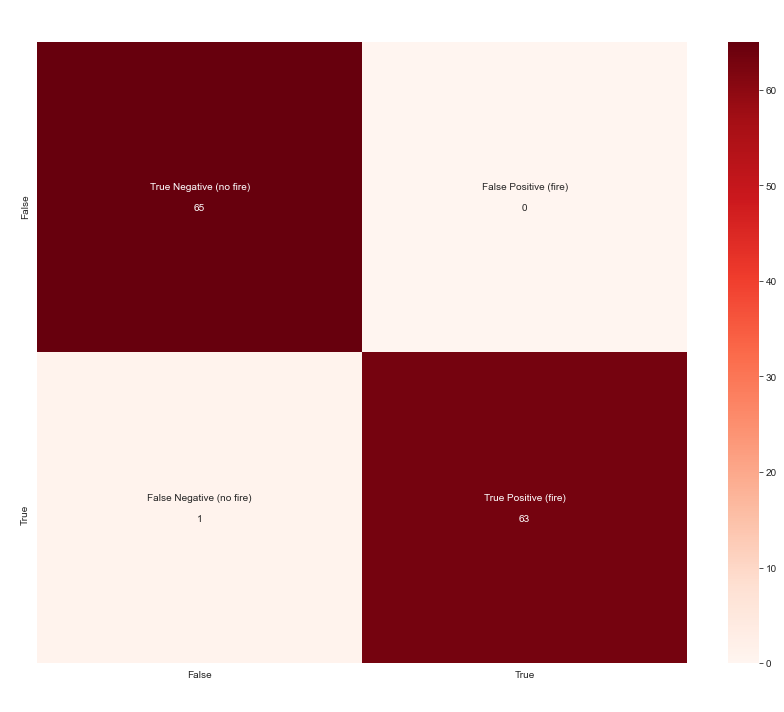

In [164]:
plot_confusion_matrix_2(modelDf['cms'].values[0],normalize=False)

In [165]:
# for model in modelz:
#     predictions2 = model.predict(x=hold_out_images, steps=len(hold_out_images), verbose=0)
#     cm2 = confusion_matrix(y_true=hold_out_labels, y_pred=np.argmax(predictions2, axis=-1))
#     plot_confusion_matrix_2(cm2,normalize=False)

31/31 [==============================] - 11s 334ms/step


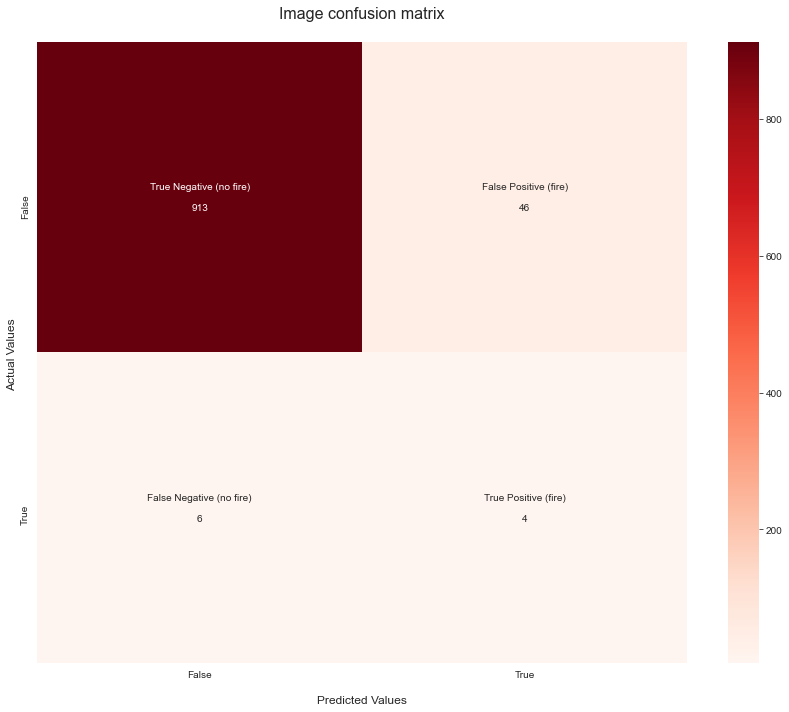

In [179]:
# #if you want to do predictions on model uncomment
predictions = model.predict(hold_out_images, verbose = 1)

scores = []
for prediction in predictions:
    if prediction >= .75:
        scores.append(1)
    else:
        scores.append(0)

plot_confusion_matrix_2(confusion_matrix(y_true=hold_out_labels, y_pred=scores),normalize=False)

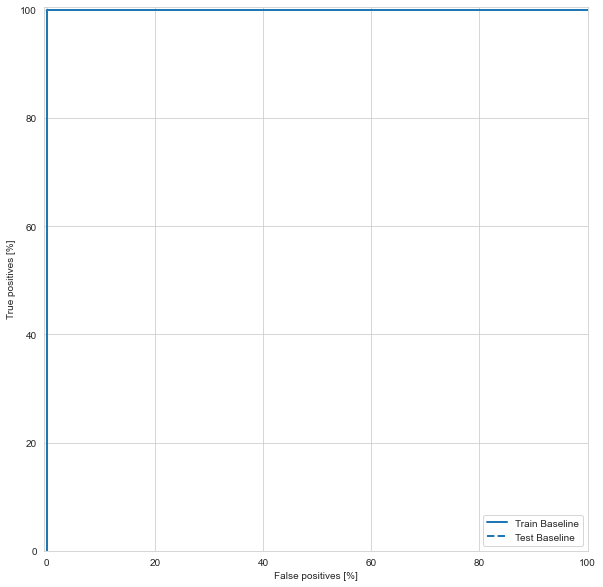

In [167]:
train_predictions_baseline = model.predict(train_images)
test_predictions_baseline = model.predict(test_images)

plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [117]:
model.save("artifacts/model_20201207.h5")

In [146]:
line_chart(histories[0])

,epoch,variable,value
0,0,accuracy,0.658252
1,0,precision,0.612727
2,0,recall,0.707983
3,0,auc,0.748223
4,0,loss,0.590575


alt.Chart(...)